## AllState Kaggle Project
#### https://www.kaggle.com/c/allstate-claims-severity

In [9]:
# Name: Jianlei(John) Sun

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

% matplotlib inline
plt.style.use('ggplot')

# Data Exploration

In [3]:
# read in the datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [4]:
test_data.head(2)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,4,A,B,A,A,A,A,A,A,B,...,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,6,A,B,A,B,A,A,A,A,B,...,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045


In [5]:
features = [x for x in train_data.columns if x not in ['id','loss']]
cat_cols = [x for x in train_data.select_dtypes(include=['object']).columns ]
con_cols = [x for x in train_data.select_dtypes(exclude=['object']).columns if x not in ['id','loss']]

# Data Transformation

In [6]:
train = train_data.drop('loss', axis = 1)
data = pd.concat((train, test_data), axis = 0, ignore_index = True)

In [7]:
# apply 'Box-Cox' transformation to eleminate skewness

from scipy.stats import skew, boxcox
skewness = train[con_cols].apply(lambda x: skew(x.dropna()))
skewness = skewness[skewness > 0.25]

for i in skewness.index:
    data[i] = data[i] + 1
    data[i], lmbda = boxcox(data[i])

In [8]:
#One-hot-encoding other categorical features (too time-consuming)

#for f in cat_cols:
#    data_dummies = pd.get_dummies(data[f], prefix=f)
    
#    data = pd.concat((data, data_dummies), axis=1)
#    data = data.drop([f], axis=1)

In [9]:
# LabelEncoding (faster)

for f in cat_cols:
    data[f] = data[f].astype('category').cat.codes

data = data.drop(['id'], axis = 1)

In [11]:
#from sklearn import preprocessing
#LBL = preprocessing.LabelEncoder()

#for f in cat_cols:
#    LBL.fit_transform(data[f])
#    data[f]=LBL.transform(data[f])
    
#data = data.drop(['id'], axis = 1)

In [12]:
#  split the "data" back to "train_data" and "test_data"

X_train = data[:train_data.shape[0]]
X_test = data[train_data.shape[0]:]
y = np.log(train_data['loss'])

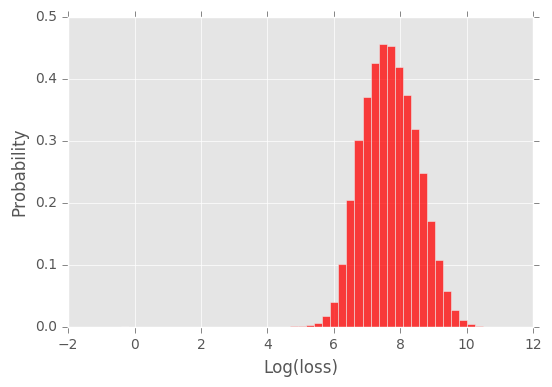

In [13]:
# histogram of log(output) shows better data balance

plt.hist(y, 50, normed = 1, facecolor='red', alpha = 0.75)
plt.xlabel('Log(loss)')
plt.ylabel('Probability')
plt.show()

# Modeling

In [14]:
# 1) build the "XGboost" prediction model

import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# define 'loss' function and error evaluation metric
n_folds = 3
early_stopping = 100
num_rounds = 100000
fair_constant = 0.7

def fair_obj(preds, dtrain):
    labels = dtrain.get_label()
    x = (preds - labels)
    den = abs(x) + fair_constant
    grad = fair_constant * x / (den)
    hess = fair_constant * fair_constant / (den * den)
    return grad, hess

def xgMetrics(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

i = 0
fpred = 0
kf = KFold(n_splits = n_folds, random_state = 2016)
d_test = xgb.DMatrix(X_test)
for i_train, i_val in kf.split(X_train):
    
    print('\n The fold %d results: \n' % (i+1))
    
    x_train, x_val = X_train.iloc[i_train], X_train.iloc[i_val]
    y_train, y_val = y.iloc[i_train], y.iloc[i_val]
    
    params = { 'seed': 2016, 'colsample_bytree': 0.7, 'silent': 1, 'subsample': 0.7,
        'learning_rate': 0.03, 'objective': 'reg:linear', 'max_depth': 12,
        'min_child_weight': 100, 'booster': 'gbtree'}

    # Create DMatrix to make xgboost more efficient
    d_train = xgb.DMatrix(x_train, label = y_train)
    d_val = xgb.DMatrix(x_val, label = y_val)
    
    watchlist = [(d_train, 'train'), (d_val, 'val')]
    
    clf = xgb.train(params, d_train, num_rounds, watchlist, early_stopping_rounds = 50,
                    obj = fair_obj, feval = xgMetrics)
    
    scores_val = clf.predict(d_val, ntree_limit = clf.best_ntree_limit)
    
    error_mae = mean_absolute_error(np.exp(y_val), np.exp(scores_val))
    print('eval-MAE: %.6f' % error_mae)
    
    y_pred = np.exp(clf.predict(d_test, ntree_limit = clf.best_ntree_limit))
    fpred = fpred + y_pred
    i = i + 1
    
fpred = fpred / n_folds



 The fold 1 results: 

[0]	train-rmse:4.87712	val-rmse:4.8747	train-mae:3020.15	val-mae:3017.43
Multiple eval metrics have been passed: 'val-mae' will be used for early stopping.

Will train until val-mae hasn't improved in 50 rounds.
[1]	train-rmse:3.79722	val-rmse:3.79455	train-mae:2983.49	val-mae:2980.71
[2]	train-rmse:3.14434	val-rmse:3.14221	train-mae:2930.07	val-mae:2927.29
[3]	train-rmse:2.70428	val-rmse:2.70196	train-mae:2866.5	val-mae:2863.6
[4]	train-rmse:2.38445	val-rmse:2.38226	train-mae:2797.97	val-mae:2795.04
[5]	train-rmse:2.14243	val-rmse:2.14007	train-mae:2728.36	val-mae:2725.3
[6]	train-rmse:1.95052	val-rmse:1.94794	train-mae:2657.94	val-mae:2654.67
[7]	train-rmse:1.7953	val-rmse:1.79263	train-mae:2589.56	val-mae:2586.09
[8]	train-rmse:1.66683	val-rmse:1.66423	train-mae:2522.7	val-mae:2519.04
[9]	train-rmse:1.55915	val-rmse:1.55642	train-mae:2458.54	val-mae:2454.57
[10]	train-rmse:1.46682	val-rmse:1.46408	train-mae:2396.44	val-mae:2392.21
[11]	train-rmse:1.38661	val-

In [103]:
# 2) build the "Gradient Boost Model"
from sklearn.ensemble import GradientBoostingRegressor

params = {'loss': 'lad', 'n_estimators': 100, 'subsample': 0.7, 'max_depth': 12,
          'learning_rate': 0.3, 'random_state': 2016, 'verbose': 100}

GB = GradientBoostingRegressor(**params)
GB.fit(X_train, y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.5618           0.0872           74.40m
         2           0.5039           0.0507           73.97m
         3           0.4646           0.0318           74.57m
         4           0.4392           0.0188           72.58m
         5           0.4225           0.0106           71.51m
         6           0.4108           0.0066           69.51m
         7           0.4026           0.0039           67.09m
         8           0.3956           0.0024           65.46m
         9           0.3903           0.0013           64.30m
        10           0.3855           0.0016           61.85m
        11           0.3825           0.0004           60.07m
        12           0.3782          -0.0001           58.66m
        13           0.3763           0.0002           56.12m
        14           0.3726          -0.0003           55.18m
        15           0.3696          -0.0001           53.10m
       

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.3, loss='lad', max_depth=12,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=2016,
             subsample=0.7, verbose=100, warm_start=False)

In [ ]:
GB.predict(X_test)
y_pred = np.exp(GB.predict(X_test))

In [11]:
# 3) use the xgboost, XGBRegressor()
import xgboost as xgb
from sklearn import grid_search
params = { 'seed': [2016], 'colsample_bytree': [0.7], 'silent': [False], 'subsample': [0.7],
        'learning_rate': [0.03], 'objective': ['reg:linear'], 'max_depth': [12],
        'min_child_weight': [100]}

xgb_sk = grid_search.GridSearchCV(estimator = xgb.XGBRegressor(), param_grid = params, 
                                  scoring = 'neg_mean_absolute_error', verbose= 1, 
                                  n_jobs = -1, iid = True, refit = False, cv = 4)
xgb_sk.fit(X_train, y)
print("Best score: %0.3f" % xgb_sk.best_score_)
print("Best parameters set:", xgb_sk.best_params_)
print("Scores:", xgb_sk.grid_scores_)


Fitting 4 folds for each of 1 candidates, totalling 4 fits


//anaconda/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/envs/py27/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Best score: -0.523
('Best parameters set:', {'colsample_bytree': 0.7, 'silent': False, 'learning_rate': 0.03, 'min_child_weight': 100, 'subsample': 0.7, 'seed': 2016, 'objective': 'reg:linear', 'max_depth': 12})
('Scores:', [mean: -0.52263, std: 0.00143, params: {'colsample_bytree': 0.7, 'silent': False, 'learning_rate': 0.03, 'min_child_weight': 100, 'subsample': 0.7, 'seed': 2016, 'objective': 'reg:linear', 'max_depth': 12}])


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.8min finished


In [105]:
xgb_sk.predict(X_test)
y_pred_xgb = np.exp(xgb_sk.predict(X_test))

# Submission

In [89]:
# submmit the results

y = pd.DataFrame(fpred, columns=['loss'])

submission = pd.concat([test_data['id'], y], axis =1)
submission.to_csv('Submmission.csv', index=False)